In [1]:
import os
import cv2
import keras
import numpy as np
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Dense
from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import matplotlib.pyplot as plt

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_path = '../input/fruits-360_dataset/fruits-360/Training/'
test_path = '../input/fruits-360_dataset/fruits-360/Test/'

In [3]:
def display_random_images(count, path):
    f, ax = plt.subplots(2, count, figsize = [10, 10])
    ax = ax.ravel()
    fruit_names = sorted(os.listdir(path))
    for i in range(len(ax)):
        rand_num = int(np.random.randint(0, 77, 1))
        img_name = os.listdir(path + fruit_names[rand_num] + '/')[rand_num]
        ax[i].imshow(cv2.imread(path + fruit_names[rand_num] + '/' + img_name))
        ax[i].set_title(fruit_names[rand_num])
        plt.tight_layout()
        ax[i].axis('off')

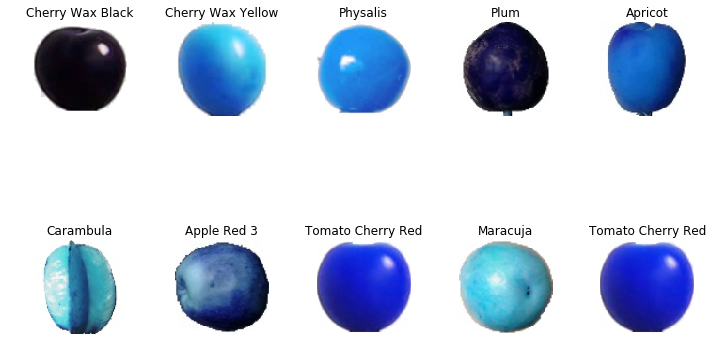

In [4]:
display_random_images(5, train_path)

In [5]:
class CustomImageDataGenerator(ImageDataGenerator):
    def standardize(self, x):
        if self.featurewise_center:
            x = ((x/255.) - 0.5) * 2.
        return x


train_generator = CustomImageDataGenerator(featurewise_center = True, samplewise_center = True, horizontal_flip = True, rotation_range = 20, 
                                    data_format = 'channels_last', validation_split = 0.2)

In [6]:
train = train_generator.flow_from_directory(directory = train_path, target_size = (100, 100),
                                           color_mode = 'rgb', batch_size = 64, subset = 'training')
val = train_generator.flow_from_directory(directory = train_path, target_size = (100, 100), 
                                         color_mode = 'rgb', batch_size = 64, subset = 'validation')

Found 30974 images belonging to 77 classes.
Found 7721 images belonging to 77 classes.


In [7]:
myModel = Sequential()
myModel.add(Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', data_format = 'channels_last', input_shape = (100, 100, 3)))
myModel.add(MaxPooling2D())
myModel.add(BatchNormalization())
#myModel.add(Dropout(0.5))

myModel.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu',))
myModel.add(MaxPooling2D())
myModel.add(BatchNormalization())
#myModel.add(Dropout(0.3))

myModel.add(Conv2D(filters = 128, kernel_size = (2,2), activation = 'relu'))
myModel.add(MaxPooling2D(strides = (1,1)))

myModel.add(Flatten())

myModel.add(Dense(units = 128, activation = 'relu'))
myModel.add(Dropout(0.3))
myModel.add(Dense(units = 77, activation = 'softmax'))

optimizer = SGD(lr = 1e-5, momentum = 0.9, nesterov = True)

In [9]:
myModel.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
History = myModel.fit_generator(generator = train, epochs = 20, validation_data = val, callbacks = [EarlyStopping()],
                                workers = 3, use_multiprocessing = True)

Epoch 1/20
484/484 [==============================] - 162s 335ms/step - loss: 3.6987 - acc: 0.1398 - val_loss: 2.9127 - val_acc: 0.3577
Epoch 2/20
484/484 [==============================] - 151s 313ms/step - loss: 2.7529 - acc: 0.3343 - val_loss: 2.1539 - val_acc: 0.5776
Epoch 3/20
484/484 [==============================] - 147s 303ms/step - loss: 2.1908 - acc: 0.4689 - val_loss: 1.6515 - val_acc: 0.6965
Epoch 4/20
484/484 [==============================] - 145s 300ms/step - loss: 1.8033 - acc: 0.5627 - val_loss: 1.2767 - val_acc: 0.7932
Epoch 5/20
484/484 [==============================] - 146s 301ms/step - loss: 1.5107 - acc: 0.6374 - val_loss: 1.0333 - val_acc: 0.8356
Epoch 6/20
484/484 [==============================] - 147s 304ms/step - loss: 1.2760 - acc: 0.6948 - val_loss: 0.8206 - val_acc: 0.8710
Epoch 7/20
484/484 [==============================] - 146s 301ms/step - loss: 1.0749 - acc: 0.7438 - val_loss: 0.7002 - val_acc: 0.8818
Epoch 8/20
484/484 [============================

In [10]:
import matplotlib.pyplot as plt
train_acc = History.history['acc']
train_loss = History.history['loss']
val_acc = History.history['val_acc']
val_loss = History.history['val_loss']

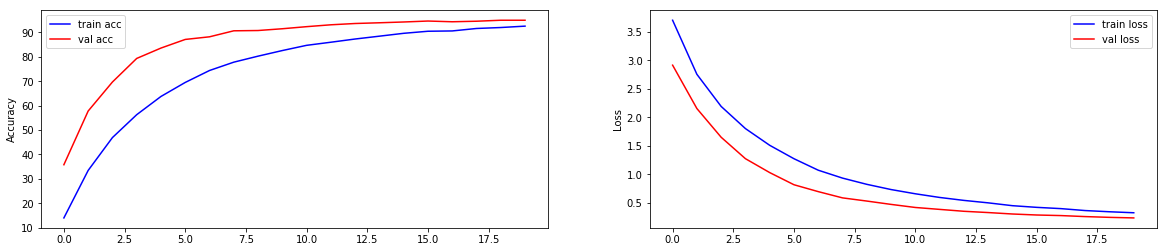

In [11]:
f, ax = plt.subplots(1,2, figsize = [20, 4])
ax = ax.ravel()
ax[0].plot(History.epoch, np.array(train_acc) * 100, color = 'b', label = 'train acc')
ax[0].plot(History.epoch, np.array(val_acc) * 100, color = 'r', label = 'val acc')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(History.epoch, train_loss, color = 'b', label = 'train loss')
ax[1].plot(History.epoch, val_loss, color = 'r', label = 'val loss')
ax[1].set_ylabel('Loss')
ax[1].legend()

In [12]:
test_generator = CustomImageDataGenerator(featurewise_center = True, samplewise_center = True, horizontal_flip = True, rotation_range = 20,
                                  data_format = 'channels_last')
test = test_generator.flow_from_directory(directory = '../input/fruits-360_dataset/fruits-360/Test/', 
                                          target_size = (100, 100), batch_size = 64)

Found 13000 images belonging to 77 classes.


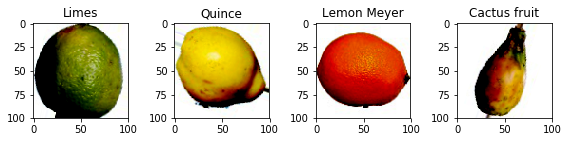

In [13]:
def test_model(num_plots):
    f, ax = plt.subplots(nrows = 1, ncols = num_plots, figsize = [8,8])
    ax = ax.ravel()
    classes = list(test.class_indices.keys())
    for index in range(len(ax)):
        img = test.next()[0][0]
        v = np.maximum(img, 0)
        img = np.expand_dims(img, 0)
        pred = np.argmax(myModel.predict(img))
        ax[index].imshow(v)
        ax[index].set_title(classes[pred])
        plt.tight_layout()
test_model(4)

In [14]:
myModel.evaluate_generator(test, workers = 4, use_multiprocessing = True)

[0.24934418357335605, 0.9372307692307692]